In [1]:
suppressPackageStartupMessages({
    source('../../R/libs.R')
    source('../../R/utils.R')
})

In [2]:
tag = "-pub"
tag = paste(tag,format(Sys.time(), "-%Y-%m-%d-%H"), sep = '')
experiment_name = 'pancreas'
model_name="dincta"
data_path = paste('../../data/',experiment_name,sep = '')
experiment_name = paste(experiment_name, tag, sep = '')
output_path = path_join('../../outputs',experiment_name,model_name)
if(!dir.exists(output_path)){
    makedirs(output_path)
}

# Prepare Data

In [3]:
exprs <- list()
exprs$celseq <- readRDS(path_join(data_path,'celseq_raw.rds'))
exprs$celseq2 <- readRDS(path_join(data_path,'celseq2_raw.rds'))
exprs$c1 <- readRDS(path_join(data_path,'c1_raw.rds'))
exprs$smartseq <- readRDS(path_join(data_path,'ss2_raw.rds'))
exprs$indrop <- readRDS(path_join(data_path,'indrop_raw.rds'))


In [4]:
for (dname in names(exprs)) {
    colnames(exprs[[dname]]) <- paste0(dname, "_", colnames(exprs[[dname]]))    
}


In [5]:
genes_common <- exprs %>% lapply(rownames) %>% purrr::reduce(intersect)
length(genes_common)

[1] 15369

In [6]:
exprs_raw <- exprs %>% 
    lapply(function(x) x[genes_common, ]) %>%
   purrr::reduce(Matrix::cbind2)


In [7]:
meta_data <- fread(path_join(data_path,'metadata.csv'))


In [8]:
head(meta_data)
table(meta_data$dataset)
table(meta_data$donor)
dim(meta_data)
dim(exprs_raw)

cell_id,dataset,nGene,donor,cell_type,cell_subtype
<chr>,<chr>,<int>,<chr>,<chr>,<chr>
celseq_D2ex_1,celseq,1968,D2,acinar,acinar
celseq_D2ex_2,celseq,2627,D2,acinar,acinar
celseq_D2ex_3,celseq,1968,D2,acinar,acinar
celseq_D2ex_4,celseq,4097,D2,ductal,ductal
celseq_D2ex_5,celseq,2334,D2,ductal,ductal
celseq_D2ex_6,celseq,2418,D2,ductal,ductal



      c1   celseq  celseq2   indrop smartseq 
     638      946     2238     8569     2355 


          AZ          D10          D17           D2          D28          D29 
          60           95          406           76          346          551 
          D3          D30          D31           D7    HP1502401 HP1504101T2D 
         106          679          662          263          251          254 
   HP1504901    HP1506401    HP1507101 HP1508501T2D    HP1509101 HP1525301T2D 
         192          261          280          294          175          285 
HP1526901T2D           X1          X10          X11          X12          X13 
         303           34           56           37           57           51 
          X2           X3           X4           X5           X6           X7 
          49           53           57           45           48           55 
          X8           X9       human1       human2       human3       human4 
          39           57         1937         1724         3605         1303 

[1] 14746     6

[1] 15369 17521

In [9]:
meta_data <- meta_data %>% subset(
    (dataset == "indrop" & nGene > 500) | 
    (dataset == "celseq" & nGene > 1750) |
    (dataset == "celseq2" & nGene > 2500) |    
    (dataset == "c1" & nGene > 0) |
    (dataset == "smartseq" & nGene > 2500)
)

In [10]:
genes_use <- which(Matrix::rowSums(exprs_raw[, meta_data$cell_id] != 0) >= 10)
genes_use <- genes_use[which(!grepl('^MT-', names(genes_use)))]
exprs_raw_clean <- exprs_raw[genes_use, meta_data$cell_id] 

In [11]:
print(dim(meta_data))
print(dim(exprs_raw_clean))

[1] 14746     6
[1] 15193 14746


In [12]:
save(meta_data,exprs_raw_clean,file=path_join(data_path,'pancreas_exprs_raw_clean_and_meta_data.RData'))

In [13]:
# Normalize data (log CP10K)

In [14]:
exprs_norm <- exprs_raw_clean %>% 
    normalizeData(method = 'log', 1e4)

In [15]:
# Select variable genes

In [16]:
vargenes_df <- singlecellmethods::findVariableGenes(exprs_norm, meta_data$dataset)
var_genes <- unique(data.table(vargenes_df)[, head(.SD[order(-gene_dispersion_scaled)], 1000), by = group][, symbol])

In [17]:
length(var_genes)
print(dim(meta_data))
print(dim(exprs_norm))

[1] 2543

[1] 14746     6
[1] 15193 14746


In [18]:
# PCA embedding

In [19]:
pca_res <- exprs_norm[var_genes, ] %>% 
    singlecellmethods::scaleData() %>% 
    irlba::irlba(30)
pca_embedding <- pca_res$v %*% diag(pca_res$d)        

In [20]:
# UMAP embedding

In [21]:
pca_umap <- do_umap(pca_embedding)

In [22]:
saveRDS(exprs_raw, path_join(output_path,'exprs_raw.rds'))
saveRDS(meta_data,path_join(output_path,'meta_data.rds' ))
saveRDS(pca_embedding,path_join(output_path,'pca_embedding.rds'))
saveRDS(pca_umap,path_join(output_path,'pca_umap.rds'))

In [23]:
pca_embedding = readRDS(path_join(output_path,'pca_embedding.rds'))
meta_data = readRDS(path_join(output_path,'meta_data.rds' ))
pca_umap = readRDS(path_join(output_path,'pca_umap.rds' ))


In [24]:
#parameters 
dataset = c('dataset','donor')
cell_type = 'cell_type'
do_pca = FALSE
sigma.entropy = 0.1
sigma.cell_type = 0.1
theta.batch=c(2,1)
mu=0.01
nclust=NULL
verbose=T
plot_convergence = T
R.cross.entropy.type ='bc'
return_object = T
max.iter.dincta=20 
frequency.update.Phi_C = 3
alphas=rep(0.5,max.iter.dincta)
keep.known.cell_type=FALSE
refine.Phi_C = FALSE
max.times.refine.Phi_C = c(20,10,5,3,2)
select.refine.fraction = 0.2
epsilon.cell_type.changed = 1e-2
epsilon.cells.type.changed_frequence = 1e-7
n.cell_type.residual = 12
k_cluster.n.cells.outer.threshold =10.
k_cluster.n.cells.inner.threshold =1.
new.cell_type.prob.threshold=0.8
cell_type.sample.fraction=0.9
new.cell_type.main.fraction = 0.9
cell_type.eigval.threshold=0.98
new.cell_type.min.cells = 10
cell_type.min.cells=10
centroid.cor.threshold = 0.6


# Dincta

In [25]:

# mask cell type
fake_cell_type = mask_celltype(meta_data,"cell_type",mask_var_use='dataset', mask_var_values_use = c('celseq2'))

table(meta_data[['cell_type']])
fake_cell_type[fake_cell_type=='alpha'] = 'unknown'
table(fake_cell_type)

meta_data[["fake_cell_type"]] = fake_cell_type
table(fake_cell_type)


                 acinar       alpha        beta       delta      ductal 
        290        1863        4399        3617         958        1908 
endothelial     epsilon       gamma      immune      neural 
        304          25         587         114         681 

fake_cell_type
                 acinar        beta       delta      ductal endothelial 
        290        1585        3159         770        1652         283 
    epsilon       gamma      immune      neural     unknown 
         25         485          96         571        5830 

fake_cell_type
                 acinar        beta       delta      ductal endothelial 
        290        1585        3159         770        1652         283 
    epsilon       gamma      immune      neural     unknown 
         25         485          96         571        5830 

Warning message:
“The `x` argument of `as_tibble.matrix()` must have unique column names if `.name_repair` is omitted as of tibble 2.0.0.
Using compatibility `.name_repair`.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”
Dincta 1/20

Dincta 2/20

Dincta 3/20

Dincta 4/20

Dincta 5/20

Dincta 6/20

Dincta 7/20

Dincta 8/20

Dincta 9/20

Dincta 10/20

Dincta 11/20

Dincta converged after 11 iterations



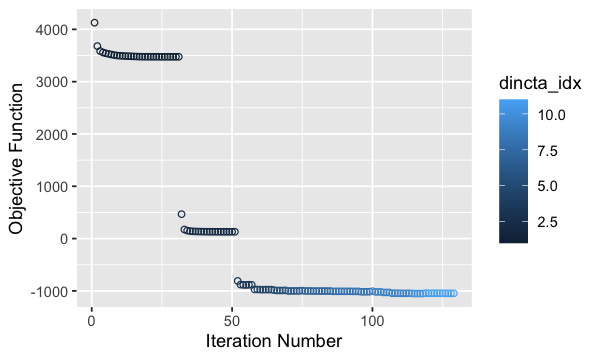

In [26]:
fig.size(3, 5)
# name dincta_[full|partial]_[bc|b]_obj

R.cross.entropy.type = 'bc'
cell_type = "fake_cell_type"
max.times.refine.Phi_C = c(20,10,5,3,2)
dincta_partial_unknown_res <- dincta::DinctaMatrix(pca_embedding, meta_data, dataset, cell_type, do_pca = do_pca,
                                           theta.batch=theta.batch, mu=mu,
                                           sigma.entropy = sigma.entropy,
                                           sigma.cell_type = sigma.cell_type,
                                           verbose=verbose, plot_convergence = plot_convergence,
                                           R.cross.entropy.type = R.cross.entropy.type,
                                           return_object = return_object, alphas=alphas,
                                              refine.Phi_C = refine.Phi_C,
                                              nclust = 100,
                                           frequency.update.Phi_C = frequency.update.Phi_C,
                                              n.cell_type.residual =n.cell_type.residual,
                                                          k_cluster.n.cells.outer.threshold =k_cluster.n.cells.outer.threshold,
k_cluster.n.cells.inner.threshold =k_cluster.n.cells.inner.threshold,
new.cell_type.prob.threshold=new.cell_type.prob.threshold,
cell_type.sample.fraction=cell_type.sample.fraction,
new.cell_type.main.fraction = new.cell_type.main.fraction,
cell_type.eigval.threshold=cell_type.eigval.threshold,
                                              new.cell_type.min.cells=new.cell_type.min.cells,
                                                   cell_type.min.cells=cell_type.min.cells,
                                                   centroid.cor.threshold =centroid.cor.threshold ,
                                           max.iter.dincta = max.iter.dincta,
                                              select.refine.fraction = select.refine.fraction,
                                                   keep.known.cell_type = T,
    epsilon.cell_type.changed = epsilon.cell_type.changed)
dincta_partial_unknown_obj = dincta_partial_unknown_res[[1]]
dincta_partial_unknown_meta_data = dincta_partial_unknown_res[[2]]

In [27]:
fake_cell_type = rep("unknown", length(meta_data[["cell_type"]]))
meta_data[["fake_cell_type"]] = fake_cell_type

table(fake_cell_type)

fake_cell_type
unknown 
  14746 

Dincta 1/20

Dincta 2/20

Dincta 3/20

Dincta 4/20

Dincta 5/20

Dincta 6/20

Dincta 7/20

Dincta 8/20

Dincta 9/20

Dincta 10/20

Dincta 11/20

Dincta converged after 11 iterations



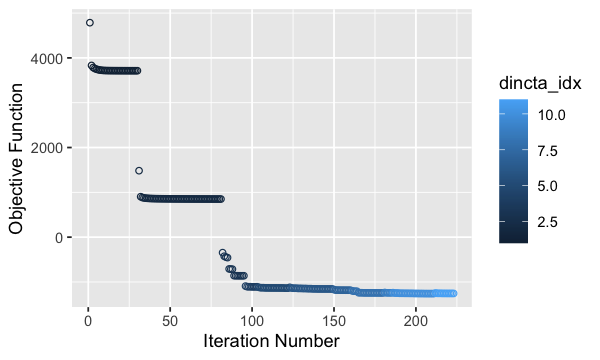

In [28]:
fig.size(3, 5)
# name dincta_[full|partial]_[bc|b]_obj

R.cross.entropy.type = 'bc'
cell_type = "fake_cell_type"
dincta_whole_unknown_res <- dincta::DinctaMatrix(pca_embedding, meta_data, dataset, cell_type, do_pca = do_pca,
                                           theta.batch=theta.batch, mu=mu,
                                           sigma.entropy = sigma.entropy,
                                           sigma.cell_type = sigma.cell_type,
                                           verbose=verbose, plot_convergence = plot_convergence,
                                           R.cross.entropy.type = R.cross.entropy.type,
                                           return_object = return_object, alphas=alphas,
                                              refine.Phi_C = refine.Phi_C,
                                              nclust = nclust,
                                           frequency.update.Phi_C = frequency.update.Phi_C,
                                              n.cell_type.residual =n.cell_type.residual,
                                                          k_cluster.n.cells.outer.threshold =k_cluster.n.cells.outer.threshold,
k_cluster.n.cells.inner.threshold =k_cluster.n.cells.inner.threshold,
new.cell_type.prob.threshold=new.cell_type.prob.threshold,
cell_type.sample.fraction=cell_type.sample.fraction,
new.cell_type.main.fraction = new.cell_type.main.fraction,
cell_type.eigval.threshold=cell_type.eigval.threshold,
                                              new.cell_type.min.cells=new.cell_type.min.cells,
                                                 cell_type.min.cells=cell_type.min.cells,
                                                  centroid.cor.threshold =centroid.cor.threshold ,
                                           max.iter.dincta = max.iter.dincta,
                                              select.refine.fraction = 0.3,keep.known.cell_type = F,
    epsilon.cell_type.changed = 1e-6)
dincta_whole_unknown_obj = dincta_whole_unknown_res[[1]]
dincta_whole_unknown_meta_data = dincta_whole_unknown_res[[2]]

Dincta 1/20

Dincta 2/20

Dincta 3/20

Dincta 4/20

Dincta 5/20

Dincta converged after 5 iterations



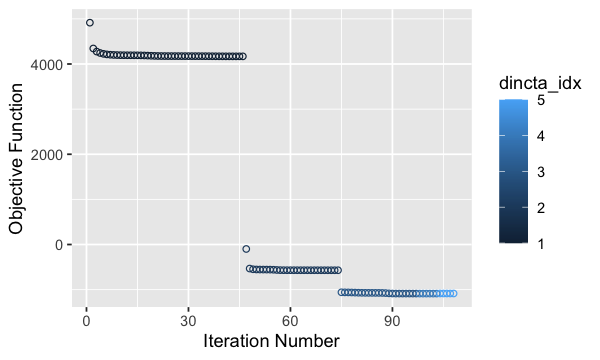

In [29]:
fig.size(3, 5)
# name dincta_[full|partial]_[bc|b]_obj
R.cross.entropy.type = 'bc'
cell_type = "cell_type"
dincta_whole_known_res <- dincta::DinctaMatrix(pca_embedding, meta_data, dataset, cell_type, do_pca = do_pca,
                                           theta.batch=theta.batch, mu=mu,
                                           sigma.entropy = sigma.entropy,
                                           sigma.cell_type = sigma.cell_type,
                                           verbose=verbose, plot_convergence = plot_convergence,
                                           R.cross.entropy.type = R.cross.entropy.type,
                                           return_object = return_object, alphas=alphas,
                                           frequency.update.Phi_C = frequency.update.Phi_C,
                                           max.iter.dincta = max.iter.dincta)
dincta_whole_known_obj = dincta_whole_known_res[[1]]
dincta_whole_known_meta_data = dincta_whole_known_res[[2]]

dincta_whole_known_embedding= get_embedding(dincta_whole_known_obj, pca_embedding)
dincta_whole_known_umap <- do_umap(dincta_whole_known_embedding)

# Harmony

Let's account for both dataset and donor in the Harmony model. Because donor effect is more mild than dataset, we give donor a smaller theta ( $\theta_{𝑑𝑜𝑛𝑜𝑟}=1$  vs  $\theta_{𝑑𝑎𝑡𝑎𝑠𝑒𝑡}=2$ ).

Harmony 1/20

Harmony 2/20

Harmony 3/20

Harmony 4/20

Harmony 5/20

Harmony 6/20

Harmony 7/20

Harmony 8/20

Harmony 9/20

Harmony converged after 9 iterations



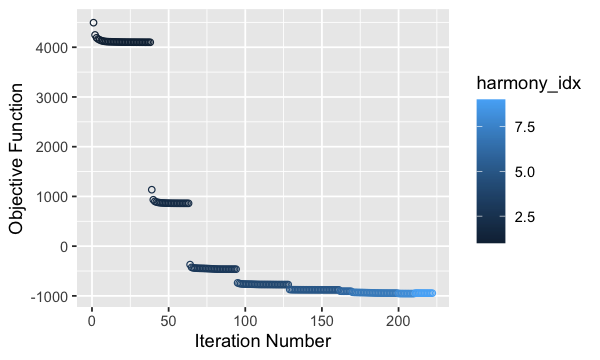

In [30]:
fig.size(3, 5)
harmony_obj <- HarmonyMatrix(
    pca_embedding, 
    meta_data,
    dataset, 
    mu=mu,
    theta=theta.batch, 
    do_pca=do_pca, 
    plot_convergence=plot_convergence,
    return_object = return_object,
    max.iter.harmony = max.iter.dincta
)

In [31]:
harmony_embedding = get_embedding(harmony_obj, pca_embedding)
harmony_umap <- do_umap(harmony_embedding)

In [32]:
dincta_partial_unknown_embedding= get_embedding(dincta_partial_unknown_obj, pca_embedding)
dincta_partial_unknown_umap <- do_umap(dincta_partial_unknown_embedding)

In [33]:

dincta_whole_unknown_embedding= get_embedding(dincta_whole_unknown_obj, pca_embedding)
dincta_whole_unknown_umap <- do_umap(dincta_whole_unknown_embedding)

In [34]:
table(as.character(dincta_partial_unknown_meta_data[["dataset"]]))
table(as.character(dincta_partial_unknown_meta_data[["cell_type"]]))
table(as.character(dincta_partial_unknown_meta_data[["fake_cell_type"]]))
table(as.character(dincta_partial_unknown_meta_data[["cell_type_predict"]]))

table(as.character(dincta_whole_unknown_meta_data[["cell_type_predict"]]))



      c1   celseq  celseq2   indrop smartseq 
     638      946     2238     8569     2355 


                 acinar       alpha        beta       delta      ductal 
        290        1863        4399        3617         958        1908 
endothelial     epsilon       gamma      immune      neural 
        304          25         587         114         681 


                 acinar        beta       delta      ductal endothelial 
        290        1585        3159         770        1652         283 
    epsilon       gamma      immune      neural     unknown 
         25         485          96         571        5830 


             V1          acinar            beta           delta          ductal 
            290            1864            3628             959            2013 
    endothelial         epsilon           gamma          immune          neural 
            304              25             589             117             683 
new_cell_type_1 
           4274 


 new_cell_type_1 new_cell_type_10 new_cell_type_11 new_cell_type_12 
              47             1852             3480             4483 
 new_cell_type_2  new_cell_type_3  new_cell_type_4  new_cell_type_5 
             106               78              307              204 
 new_cell_type_6  new_cell_type_7  new_cell_type_8  new_cell_type_9 
             602              703              957             1927 

In [35]:
#LISI
lisi_res <- rbind(
    lisi::compute_lisi(dincta_whole_known_embedding, meta_data, c('dataset', 'donor', 'cell_type')) %>% 
        dplyr::mutate(type = 'dincta_whole_known'),
    lisi::compute_lisi(dincta_partial_unknown_embedding, meta_data, c('dataset', 'donor', 'cell_type')) %>% 
        dplyr::mutate(type = 'dincta_partial_unknown'),
    lisi::compute_lisi(dincta_whole_unknown_embedding, meta_data, c('dataset',  'donor', 'cell_type')) %>% 
        dplyr::mutate(type = 'dincta_whole_unknown'),
    lisi::compute_lisi(harmony_embedding, meta_data, c('dataset', 'donor', 'cell_type')) %>% 
        dplyr::mutate(type = 'harmony'),
    lisi::compute_lisi(pca_embedding, meta_data, c('dataset', 'donor', 'cell_type')) %>% 
        dplyr::mutate(type = 'pca')
) %>% 
    tidyr::gather(key, val, cell_type, dataset, donor)


In [36]:
saveRDS(lisi_res,path_join(output_path,'lisi_res.rds'))

In [37]:
head(lisi_res)


,type,key,val
,<chr>,<chr>,<dbl>
1,dincta_whole_known,cell_type,1.000000
2,dincta_whole_known,cell_type,1.009983
3,dincta_whole_known,cell_type,1.000000
4,dincta_whole_known,cell_type,1.000000
5,dincta_whole_known,cell_type,1.000000
6,dincta_whole_known,cell_type,1.003085


In [38]:
lisi_sum(lisi_res)

,cell_type,dataset,donor
dincta_whole_known,15611.61,26178.43,61046.54
dincta_partial_unknown,15563.34,26464.56,62041.59
dincta_whole_unknown,15771.91,26589.94,61986.21
harmony,15754.07,27105.46,63440.73
pca,15643.61,15154.43,28073.64


In [39]:
options(digits = 5,continue = T)
lisi_res_table = round(lisi_mean_std(lisi_res),3)
lisi_res_table 

,cell_type mean,cell_type std,dataset mean,dataset std,donor mean,donor std
dincta_whole_known,1.059,0.188,1.775,0.675,4.140,2.039
dincta_partial_unknown,1.055,0.171,1.795,0.680,4.207,2.071
dincta_whole_unknown,1.070,0.251,1.803,0.683,4.204,2.046
harmony,1.068,0.231,1.838,0.697,4.302,2.067
pca,1.061,0.213,1.028,0.147,1.904,1.216


In [40]:
type =lisi_res$type
type_new=type
type_new[type =="dincta_whole_known"] ="dincta_w_k"
type_new[type =="dincta_partial_unknown"] ="dincta_p_u"
type_new[type =="dincta_whole_unknown"] ="dincta_w_u"
lisi_res$type_new = type_new

In [41]:
density(lisi_res$val)


Call:
	density.default(x = lisi_res$val)

Data: lisi_res$val (221190 obs.);	Bandwidth 'bw' = 0.09052

       x                y          
 Min.   : 0.728   Min.   :0.00000  
 1st Qu.: 4.105   1st Qu.:0.00038  
 Median : 7.482   Median :0.01706  
 Mean   : 7.482   Mean   :0.07388  
 3rd Qu.:10.858   3rd Qu.:0.04544  
 Max.   :14.235   Max.   :1.89786  

Warning message:
“Removed 735 rows containing non-finite values (stat_density).”
Warning message:
“Removed 21442 rows containing non-finite values (stat_density).”
Warning message:
“Removed 54183 rows containing non-finite values (stat_density).”
Warning message:
“Removed 735 rows containing non-finite values (stat_density).”
Warning message:
“Removed 21442 rows containing non-finite values (stat_density).”
Warning message:
“Removed 54183 rows containing non-finite values (stat_density).”
Warning message:
“Removed 735 rows containing non-finite values (stat_density).”
Warning message:
“Removed 21442 rows containing non-finite values (stat_density).”
Warning message:
“Removed 54183 rows containing non-finite values (stat_density).”


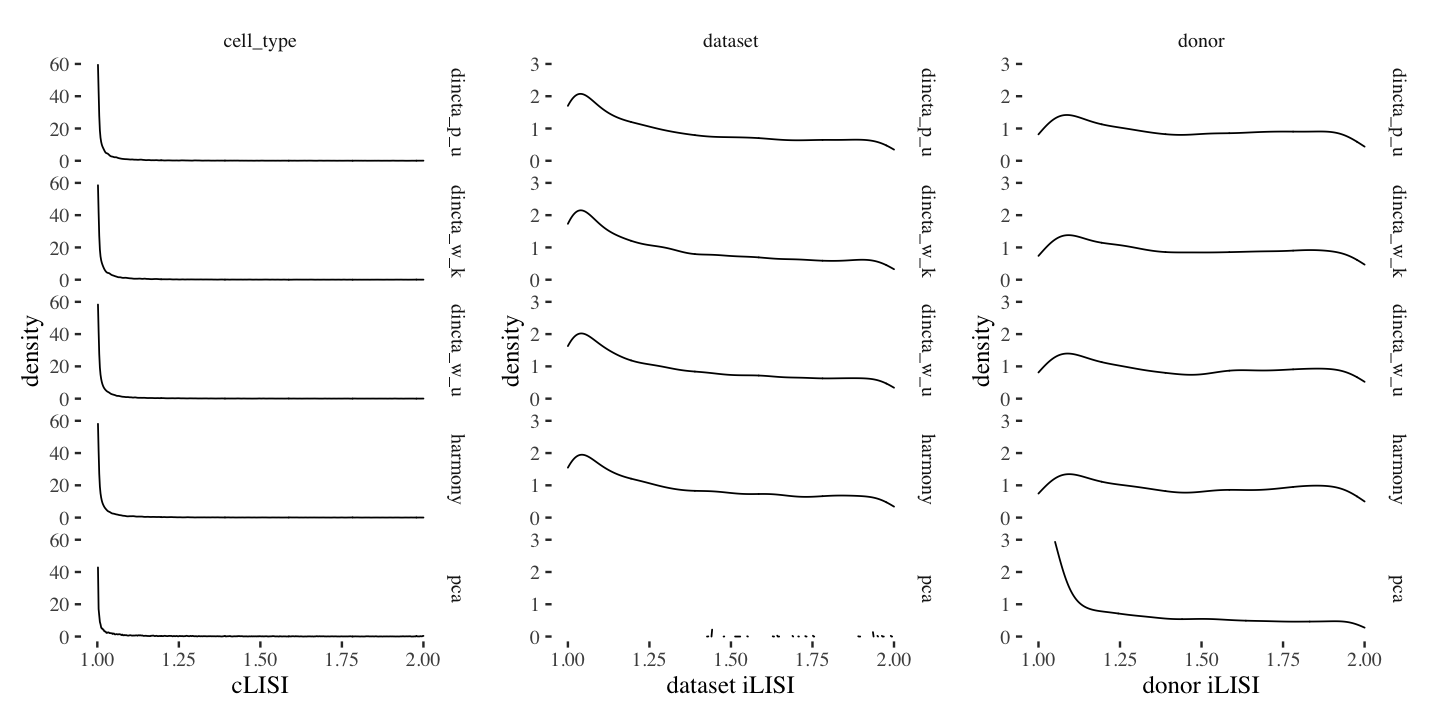

In [42]:
fig.size(6, 12)

pc = lisi_res %>% subset(key=="cell_type")%>% 
    ggplot(aes(val)) + 
        geom_density() + 
    facet_grid(vars(type_new), vars(key), scales = 'free',space="free_y", margins = "vs")+
    theme_tufte(base_size = 15) +
        xlim(1, 2) +
        ylim(0,60) +  labs(x = "cLISI")

pdataset = lisi_res %>% subset(key=="dataset")%>% 
    ggplot(aes(val)) + 
        geom_density() + 
facet_grid(vars(type_new), vars(key), scales = 'free',
           space="free_y",
           margins = "vs"
          )+
        theme_tufte(base_size = 15) +
        xlim(1, 2) +
        ylim(0,3) +  labs(x = "dataset iLISI")
pdonor = lisi_res %>% subset(key=="donor")%>% 
    ggplot(aes(val)) + 
        geom_density() + 
facet_grid(vars(type_new), vars(key), scales = 'free',
           space="free_y",
           margins = "vs"
          )+
    theme_tufte(base_size = 15) +
        xlim(1, 2) +
        ylim(0,3) +  labs(x = "donor iLISI")

pc+ pdataset+ pdonor+ guides(col = FALSE, fill = FALSE)
ggsave(path_join(output_path,'lisi_res.eps'), device = "eps",fonts=c("serif", "Palatino"),
       scale = 1, width = 12, height = 6, dpi = 600, limitsize = TRUE)
ggsave(path_join(output_path,'lisi_res.pdf'), device = "pdf",fonts=c("serif", "Palatino"),
       scale = 1, width = 12, height = 6, dpi = 600, limitsize = TRUE)

In [43]:
# Figures

In [44]:
colors_white = c(`white_1`   = paste0("#", paste0(toupper(as.hexmode(c(253, 253, 253))), collapse = "")),
                `white_2`    = paste0("#", paste0(toupper(as.hexmode(c(253, 253, 253))), collapse = "")),
                `white_3`    = paste0("#", paste0(toupper(as.hexmode(c(253, 253, 253))), collapse = "")),
                `white_4`    = paste0("#", paste0(toupper(as.hexmode(c(253, 253, 253))), collapse = "")),
                `white_5`    = paste0("#", paste0(toupper(as.hexmode(c(253, 253, 253))), collapse = "")),
                `white_6`    = paste0("#", paste0(toupper(as.hexmode(c(253, 253, 253))), collapse = "")),
                `white_7`    = paste0("#", paste0(toupper(as.hexmode(c(253, 253, 253))), collapse = "")),
                `white_8`    = paste0("#", paste0(toupper(as.hexmode(c(253, 253, 253))), collapse = "")),
                `white_9`    = paste0("#", paste0(toupper(as.hexmode(c(253, 253, 253))), collapse = "")))

In [45]:
colors_use <- c(`jurkat` = paste0("#", paste0(toupper(as.hexmode(c(129, 15, 124))), collapse = "")),
  `t293` = paste0("#", paste0(toupper(as.hexmode(c(208, 158, 45))), collapse = "")),
   `half` = paste0("#", paste0(toupper(as.hexmode(c(0, 109, 44))), collapse = "")),
                `unknown`    = paste0("#", paste0(toupper(as.hexmode(c(233, 0, 0))), collapse = "")),
                `new_cell_type_1`    = paste0("#", paste0(toupper(as.hexmode(c(16, 0, 253))), collapse = "")),
                `new_cell_type_2`    = paste0("#", paste0(toupper(as.hexmode(c(16, 253, 0))), collapse = "")),
                `new_cell_type_3`    = paste0("#", paste0(toupper(as.hexmode(c(166, 0, 0))), collapse = "")),
                `new_cell_type_4`    = paste0("#", paste0(toupper(as.hexmode(c(166, 166, 0))), collapse = "")),
                `new_cell_type_5`    = paste0("#", paste0(toupper(as.hexmode(c(166, 0, 166))), collapse = "")),
                `new_cell_type_6`    = paste0("#", paste0(toupper(as.hexmode(c(0, 166, 166))), collapse = "")),
                `new_cell_type_7`    = paste0("#", paste0(toupper(as.hexmode(c(80, 0, 0))), collapse = "")),
                `new_cell_type_8`    = paste0("#", paste0(toupper(as.hexmode(c(0, 80, 0))), collapse = "")),
                `new_cell_type_9`    = paste0("#", paste0(toupper(as.hexmode(c(0, 0, 80))), collapse = ""))
               )

In [46]:
colors_use <- readRDS(path_join(data_path,'colors.rds'))

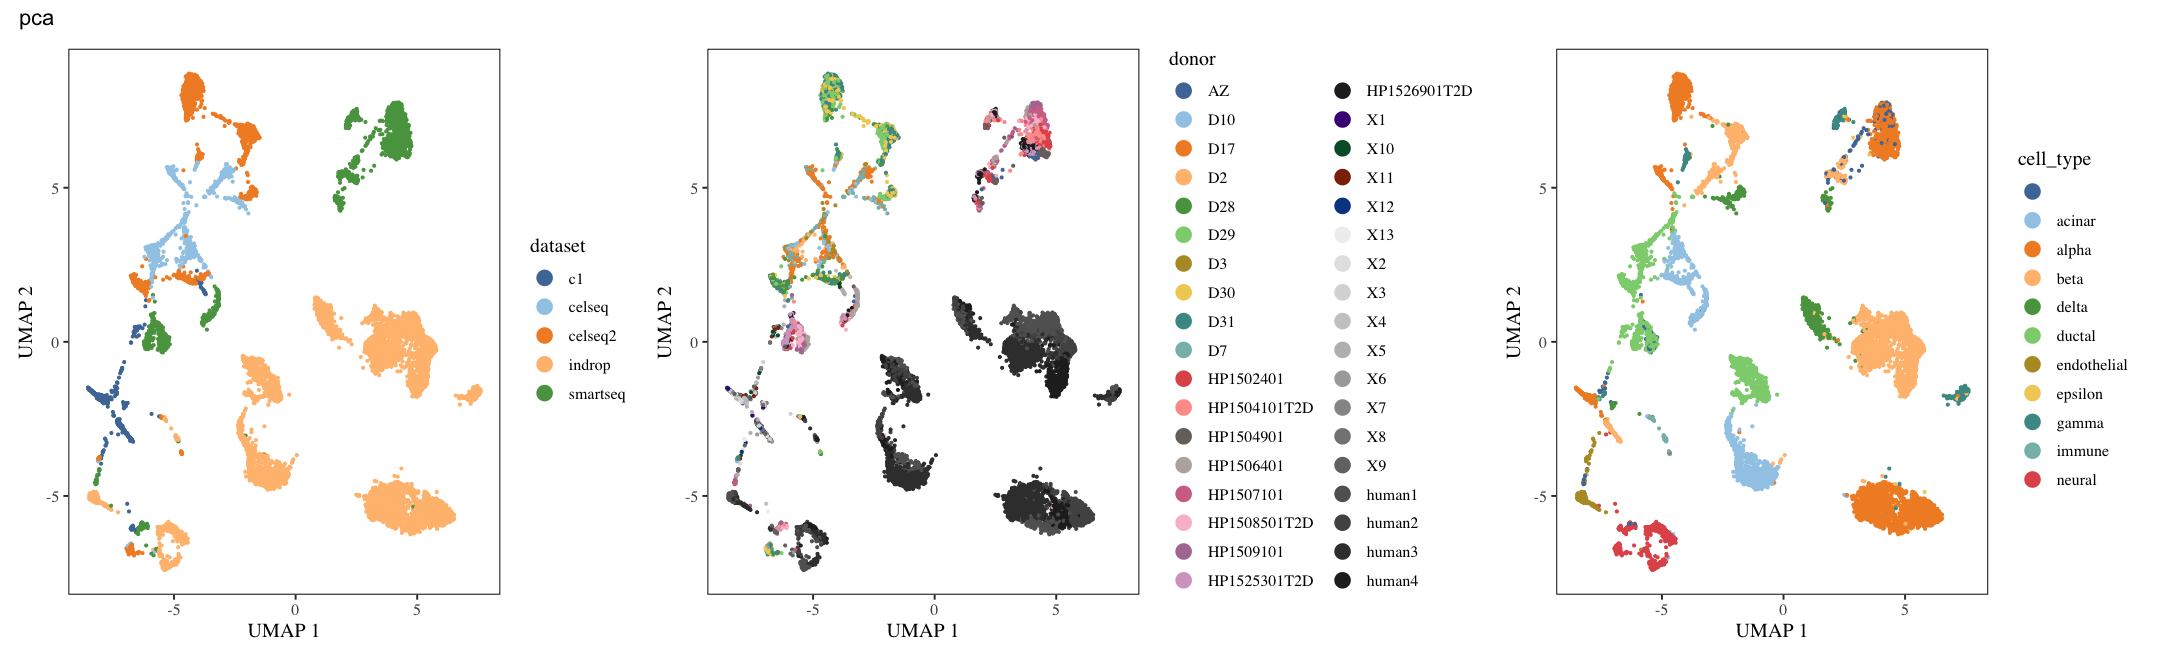

In [47]:
fig.size(5.5, 18)
do_scatter(pca_umap, meta_data, 'dataset', palette_use = colors_use, pt_shape = 21, pt_size = .2) + 
do_scatter(pca_umap, meta_data, 'donor', palette_use = colors_use, pt_shape = 21, pt_size = .2) + 
do_scatter(pca_umap, meta_data, 'cell_type', palette_use = colors_use, pt_shape = 21, pt_size = .2) + 
plot_annotation(title = 'pca')
ggsave(path_join(output_path,'pca.eps'), device = "eps",fonts=c("serif", "Palatino"),
       scale = 1, width = 18, height = 5.5, dpi = 600, limitsize = TRUE)
ggsave(path_join(output_path,'pca.pdf'), device = "pdf",fonts=c("serif", "Palatino"),
       scale = 1, width = 18, height = 5.5, dpi = 600, limitsize = TRUE)

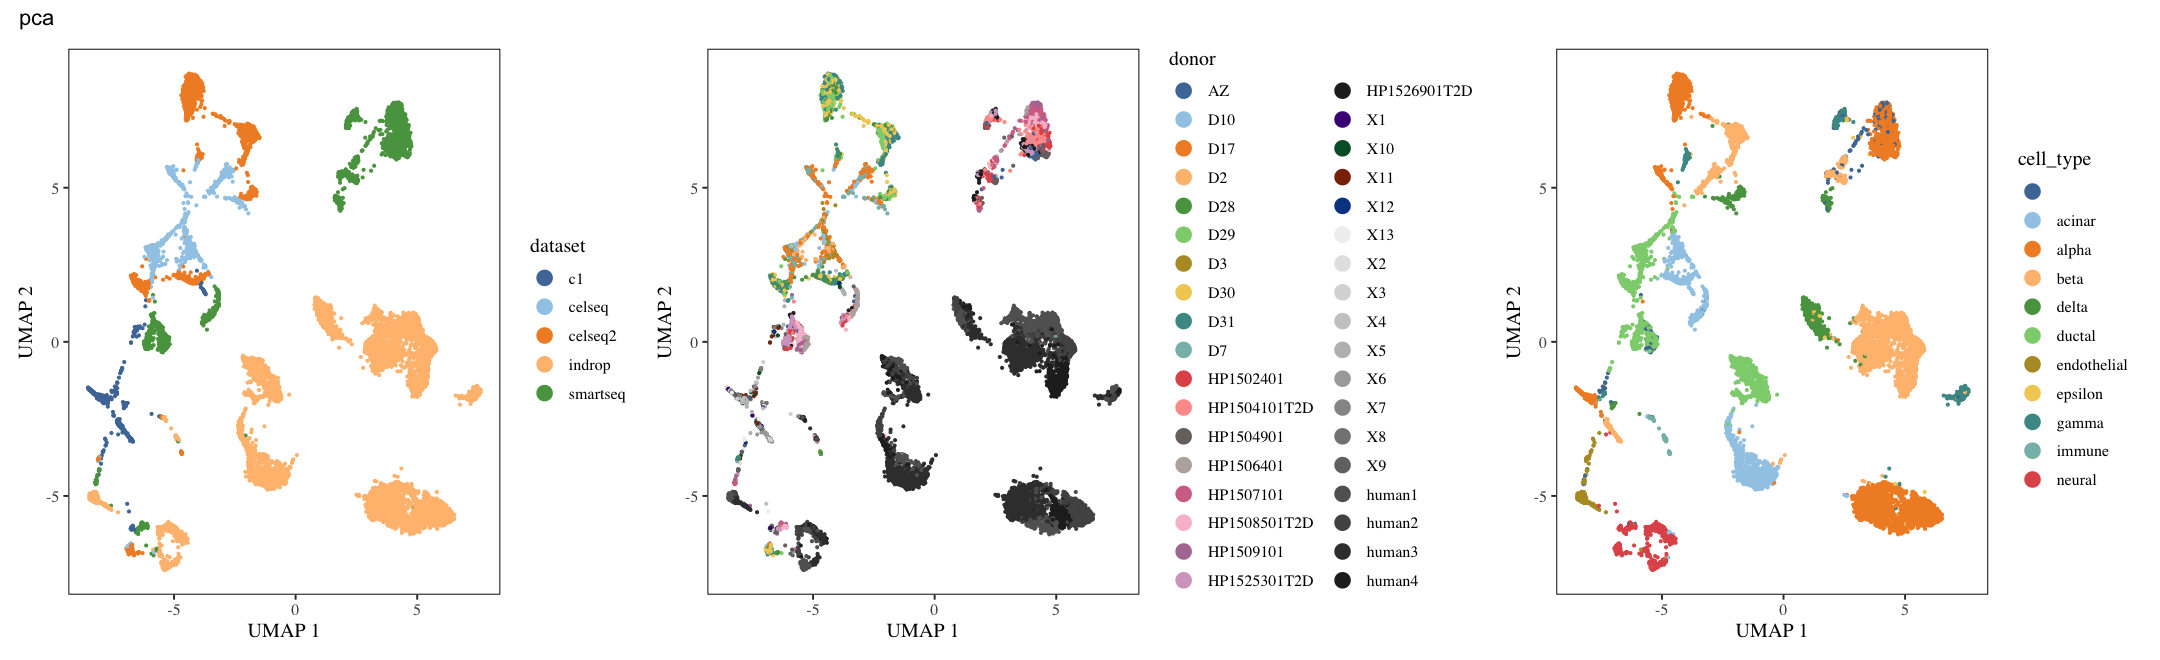

In [48]:
fig.size(5.5, 18)
do_scatter(pca_umap, meta_data, 'dataset', palette_use = colors_use, pt_shape = 21, pt_size = .2) + 
do_scatter(pca_umap, meta_data, 'donor', palette_use = colors_use, pt_shape = 21, pt_size = .2) + 
do_scatter(pca_umap, meta_data, 'cell_type', palette_use = colors_use, pt_shape = 21, pt_size = .2) + 
plot_annotation(title = 'pca')
ggsave(path_join(output_path,'pca.eps'), device = "eps",fonts=c("serif", "Palatino"),
       scale = 1, width = 18, height = 5.5, dpi = 600, limitsize = TRUE)
ggsave(path_join(output_path,'pca.pdf'), device = "pdf",fonts=c("serif", "Palatino"),
       scale = 1, width = 18, height = 5.5, dpi = 600, limitsize = TRUE)

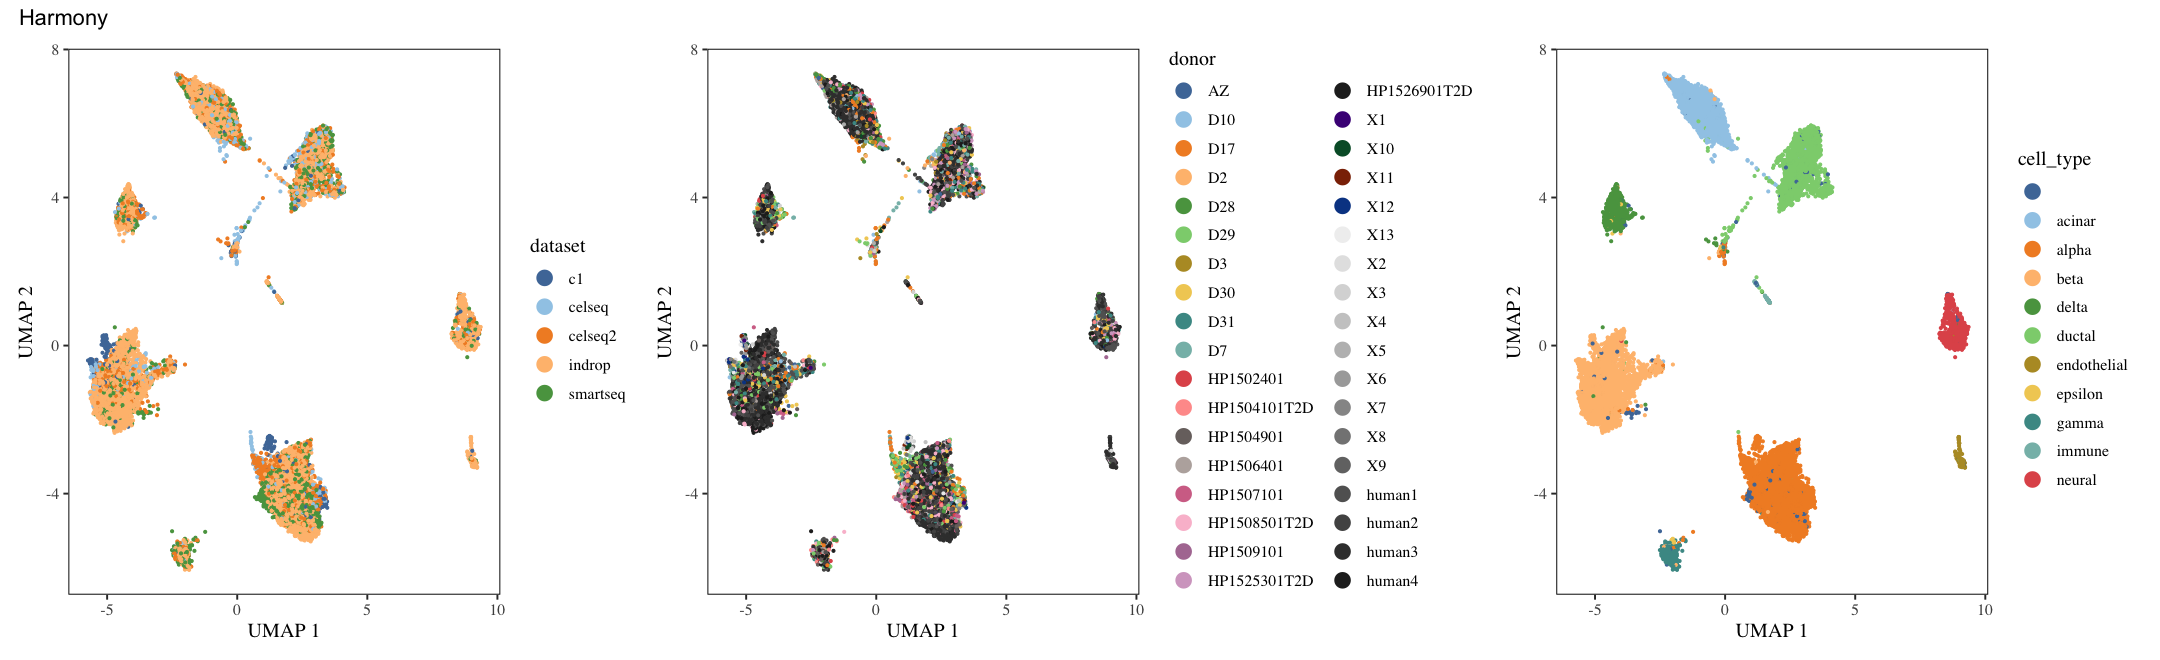

In [49]:
fig.size(5.5, 18)
do_scatter(harmony_umap, meta_data, 'dataset', palette_use = colors_use, pt_shape = 21, pt_size = .2) + 
do_scatter(harmony_umap, meta_data, 'donor', palette_use = colors_use, pt_shape = 21, pt_size = .2) + 
do_scatter(harmony_umap, meta_data, 'cell_type', palette_use = colors_use, pt_shape = 21, pt_size = .2) + 
plot_annotation(title = 'Harmony')
ggsave(path_join(output_path,'harmony.eps'), device = "eps",fonts=c("serif", "Palatino"),
       scale = 1, width = 18, height = 5.5, dpi = 600, limitsize = TRUE)
ggsave(path_join(output_path,'harmony.pdf'), device = "pdf",fonts=c("serif", "Palatino"),
       scale = 1, width = 18, height = 5.5, dpi = 600, limitsize = TRUE)

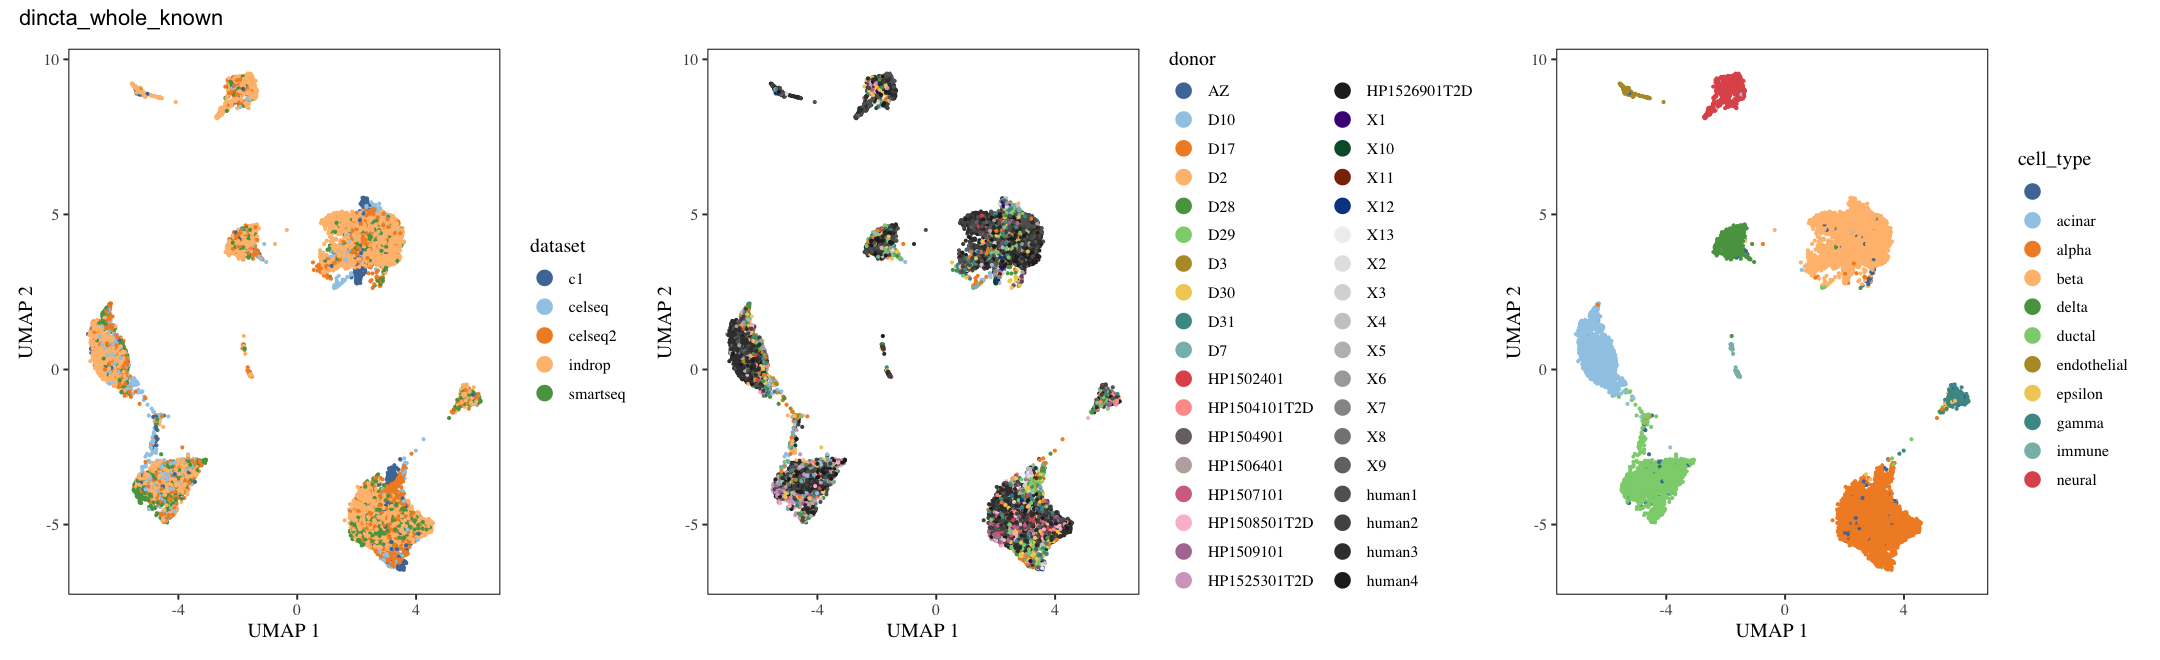

In [50]:
fig.size(5.5, 18)
do_scatter(dincta_whole_known_umap, meta_data, 'dataset', palette_use = colors_use, 
           pt_shape = 21, pt_size = .2) + 
do_scatter(dincta_whole_known_umap, meta_data, 'donor', palette_use = colors_use,
           pt_shape = 21, pt_size = .2) + 
do_scatter(dincta_whole_known_umap, meta_data, 'cell_type', palette_use = colors_use,
           pt_shape = 21, pt_size = .2) + 
plot_annotation(title = 'dincta_whole_known')
ggsave(path_join(output_path,'dincta_whole_known.eps'), device = "eps",fonts=c("serif", "Palatino"),
       scale = 1, width = 18, height = 5.5, dpi = 600, limitsize = TRUE)
ggsave(path_join(output_path,'dincta_whole_known.pdf'), device = "pdf",fonts=c("serif", "Palatino"),
       scale = 1, width = 18, height = 5.5, dpi = 600, limitsize = TRUE)

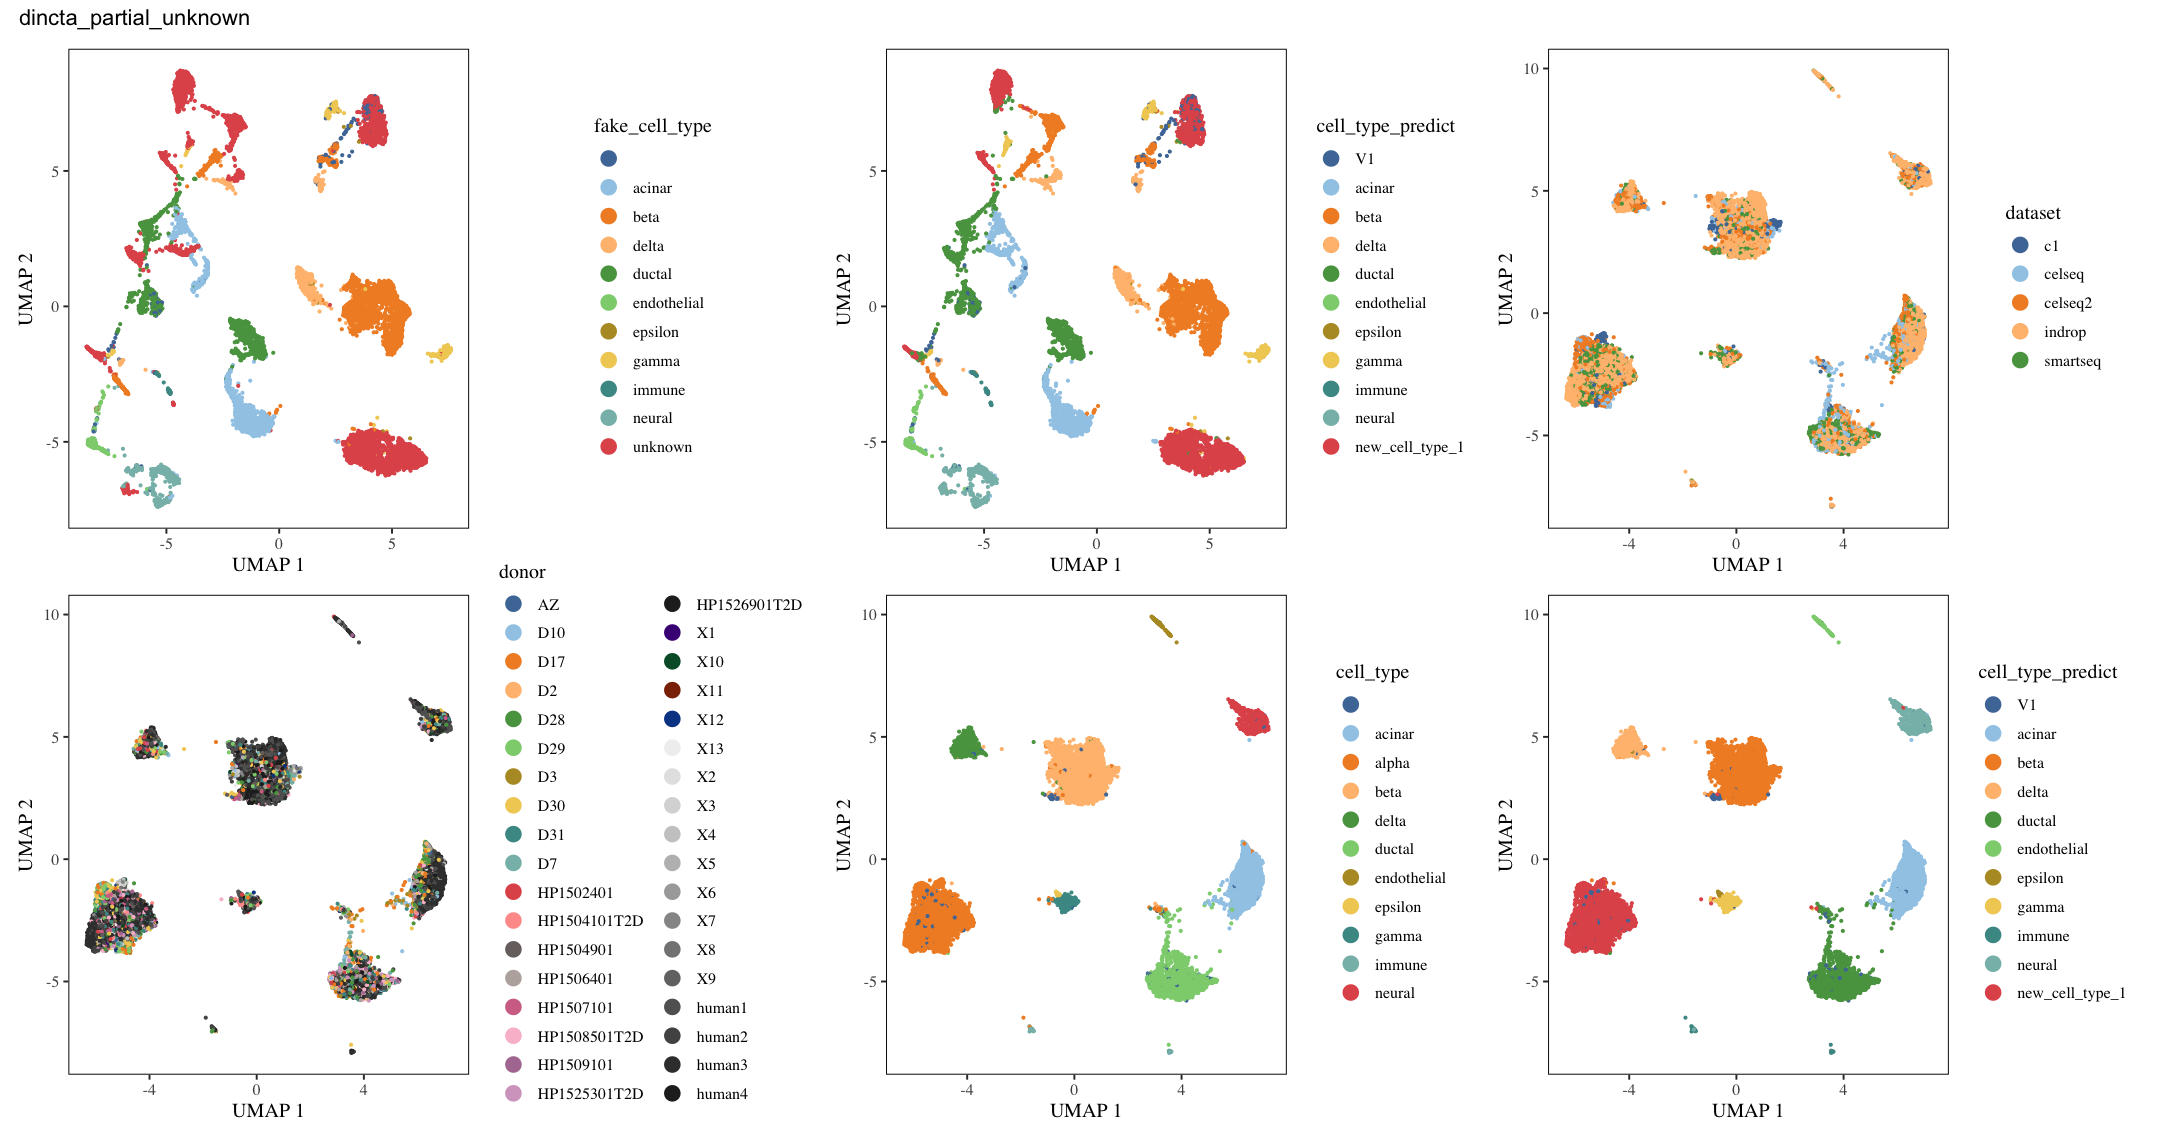

In [51]:
fig.size(9.5, 18)
do_scatter(pca_umap, dincta_partial_unknown_meta_data, 'fake_cell_type', palette_use = colors_use, pt_shape = 21, pt_size = .001) + 
do_scatter(pca_umap, dincta_partial_unknown_meta_data, 'cell_type_predict', palette_use = colors_use, pt_shape = 21, pt_size = .001) + 
do_scatter(dincta_partial_unknown_umap, meta_data, 'dataset', palette_use = colors_use, 
           pt_shape = 21, pt_size = .2) + 
do_scatter(dincta_partial_unknown_umap, meta_data, 'donor', palette_use = colors_use,
           pt_shape = 21, pt_size = .2) + 
do_scatter(dincta_partial_unknown_umap, meta_data, 'cell_type', palette_use = colors_use,
           pt_shape = 21, pt_size = .2) + 
do_scatter(dincta_partial_unknown_umap, dincta_partial_unknown_meta_data, 'cell_type_predict', palette_use = colors_use,
           pt_shape = 21, pt_size = .2) + 
plot_annotation(title = 'dincta_partial_unknown')
ggsave(path_join(output_path,'dincta_partial_unknown.eps'), device = "eps",fonts=c("serif", "Palatino"),
       scale = 1, width = 18, height = 9.5, dpi = 600, limitsize = F)
ggsave(path_join(output_path,'dincta_partial_unknown.pdf'), device = "pdf",fonts=c("serif", "Palatino"),
       scale = 1, width = 18, height = 9.5, dpi = 600, limitsize = F)

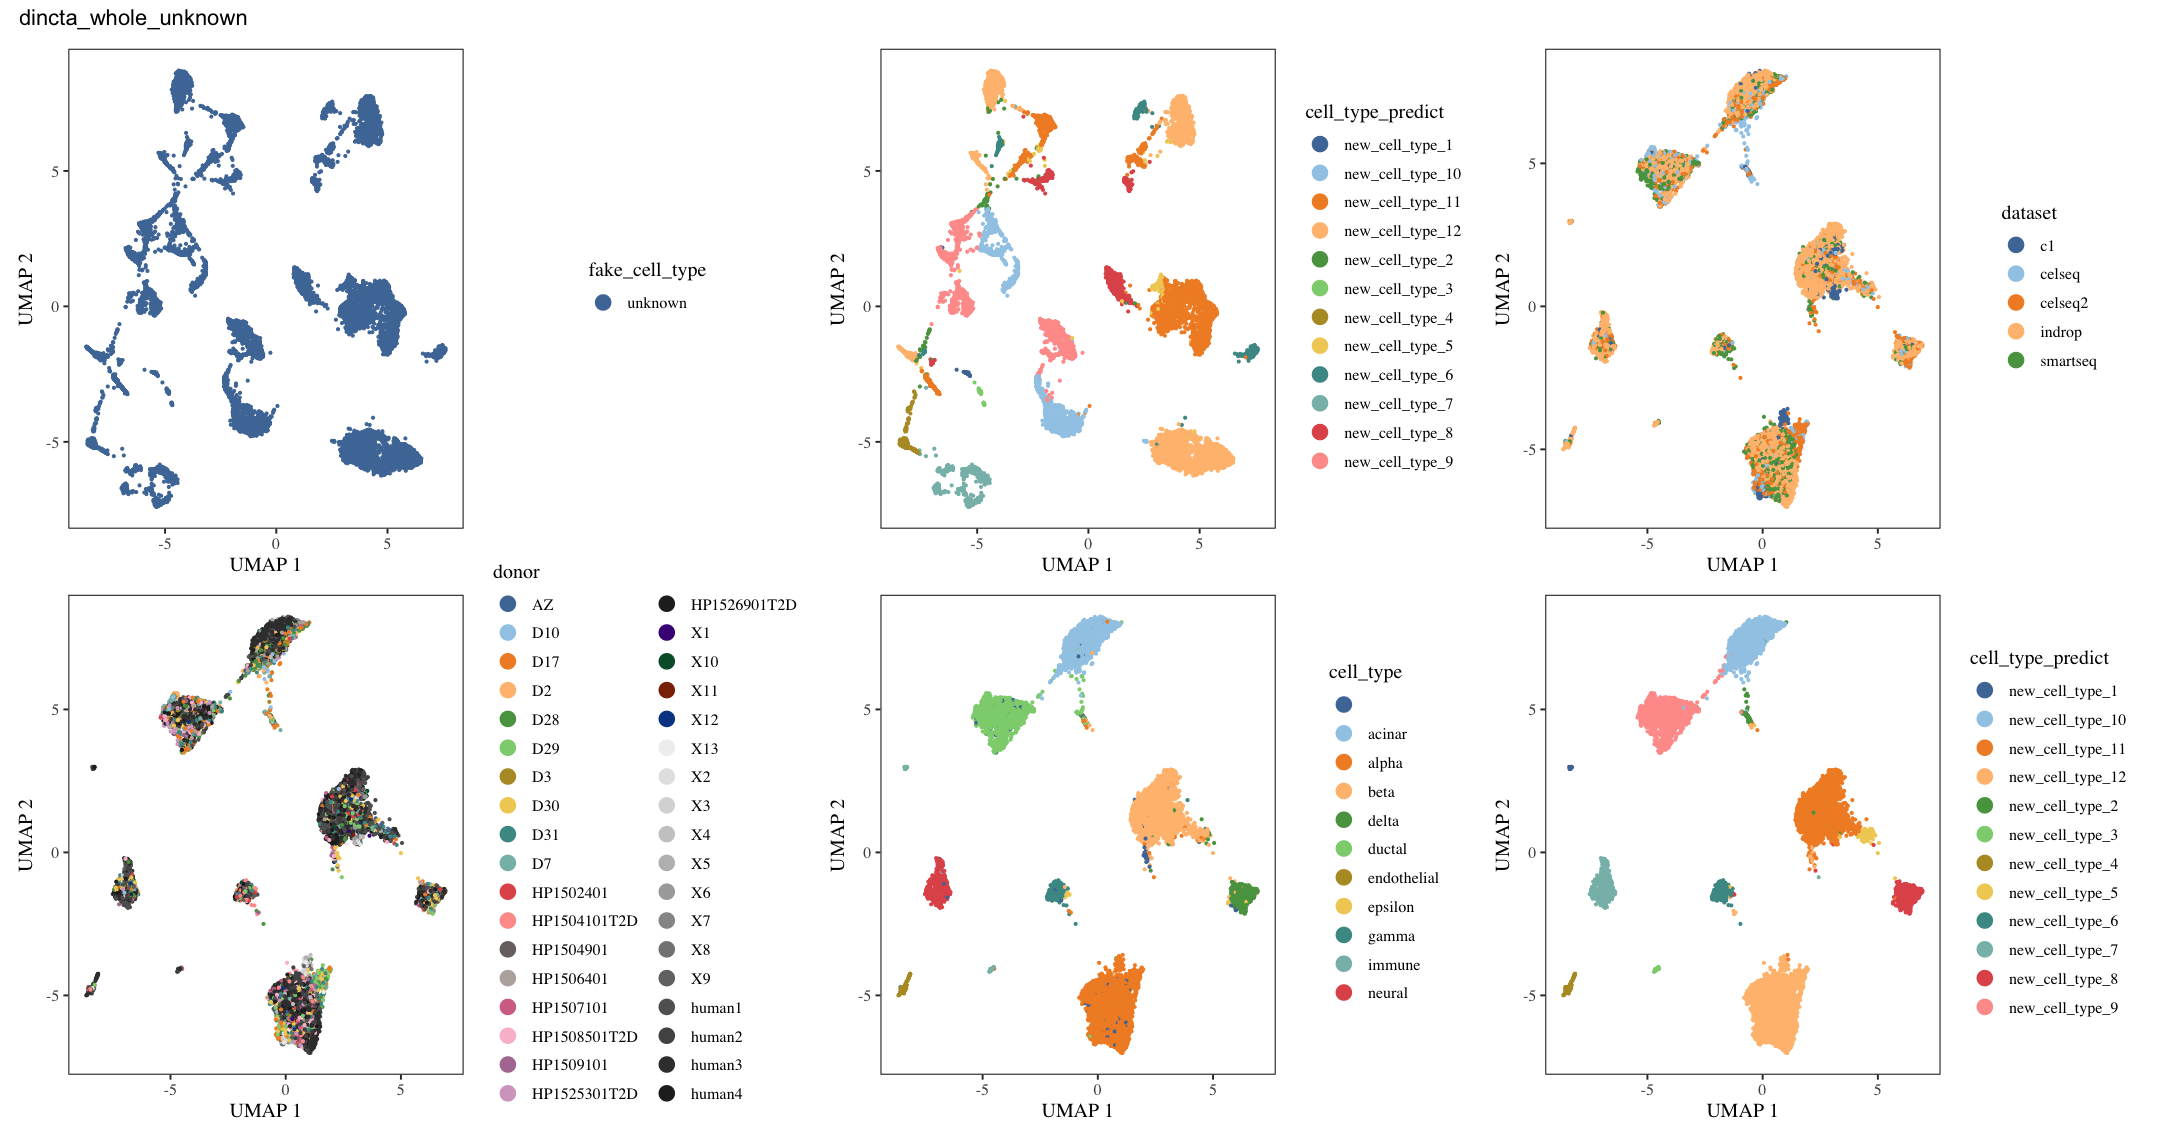

In [52]:
fig.size(9.5, 18)
do_scatter(pca_umap, dincta_whole_unknown_meta_data, 'fake_cell_type', palette_use = colors_use, pt_shape = 21, pt_size = .001) + 
do_scatter(pca_umap, dincta_whole_unknown_meta_data, 'cell_type_predict', palette_use = colors_use, pt_shape = 21, pt_size = .001) + 
do_scatter(dincta_whole_unknown_umap, meta_data, 'dataset', palette_use = colors_use, 
           pt_shape = 21, pt_size = .2) + 
do_scatter(dincta_whole_unknown_umap, meta_data, 'donor', palette_use = colors_use,
           pt_shape = 21, pt_size = .2) + 
do_scatter(dincta_whole_unknown_umap, meta_data, 'cell_type', palette_use = colors_use,
           pt_shape = 21, pt_size = .2) + 
do_scatter(dincta_whole_unknown_umap, dincta_whole_unknown_meta_data, 'cell_type_predict', palette_use = colors_use,
           pt_shape = 21, pt_size = .2) + 
plot_annotation(title = 'dincta_whole_unknown')
ggsave(path_join(output_path,'dincta_whole_unknown.eps'), device = "eps",fonts=c("serif", "Palatino"),
       scale = 1, width = 18, height = 9.5, dpi = 600, limitsize = F)
ggsave(path_join(output_path,'dincta_whole_unknown.pdf'), device = "pdf",fonts=c("serif", "Palatino"),
       scale = 1, width = 18, height = 9.5, dpi = 600, limitsize = F)

In [53]:
Phi_C = t(onehot(meta_data[['cell_type']]))
dim(Phi_C)
head(Phi_C)

[1]    11 14746

V1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
acinar,1,1,1,0,0,0,0,0,0,1,⋯,0,0,0,0,0,0,0,0,0,1
alpha,0,0,0,0,0,0,0,0,0,0,⋯,0,0,1,0,0,0,1,0,0,0
beta,0,0,0,0,0,0,0,0,0,0,⋯,1,1,0,1,1,0,0,1,1,0
delta,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ductal,0,0,0,1,1,1,1,1,1,0,⋯,0,0,0,0,0,0,0,0,0,0


In [54]:
objs =list()
objs$harmony = harmony_obj
objs$dincta_whole_known = dincta_whole_known_obj
objs$dincta_partial_unknown = dincta_partial_unknown_obj
objs$dincta_whole_unknown = dincta_whole_unknown_obj

In [55]:
summary_entropy_error_table = summary_entropy_error(objs,Phi_C) 
summary_entropy_error_table

type,fro_cluster_error_loss
<fct>,<dbl>
harmony,2607.2
dincta_whole_known,1307.5
dincta_partial_unknown,1989.4
dincta_whole_unknown,2609.6


In [56]:
summary_accuracy(objs,Phi_C)

type,accuracy,correct type,total number of cells
<fct>,<dbl>,<dbl>,<dbl>
harmony,0.96175,14182,14746
dincta_whole_known,0.97755,14415,14746
dincta_partial_unknown,0.97138,14324,14746
dincta_whole_unknown,0.96379,14212,14746


In [57]:
meta_data = dincta_partial_unknown_meta_data
Psi_C = dincta_partial_unknown_res$Phi_C
print("dincta_partial_unknown")
infer_accuracy_p_u = infer_accuracy(meta_data, Psi_C, Phi_C)
infer_accuracy_p_u

[1] "dincta_partial_unknown"
[1] "There is a tie for predict type  11  chose to map to  6"


[1] 9.7043e-01 1.4310e+04 1.4746e+04

In [58]:
meta_data = dincta_whole_unknown_meta_data
Psi_C = dincta_whole_unknown_res$Phi_C
print("dincta_whole_unknown")
infer_accuracy_w_u = infer_accuracy(meta_data, Psi_C, Phi_C)
infer_accuracy_w_u

[1] "dincta_whole_unknown"
[1] "There is a tie for predict type  1  chose to map to  7"


[1] 9.6352e-01 1.4208e+04 1.4746e+04

In [59]:
infer_accuracy_R_summary_table = infer_accuracy_R_summary(objs,Phi_C,0.7,fix_C=T)
infer_accuracy_R_summary_table

,accuracy,number.of.correct.cells,number.of.total.cells
,<dbl>,<dbl>,<dbl>
harmony,0.96141,14177,14746
dincta_whole_known,0.97755,14415,14746
dincta_partial_unknown,0.97057,14312,14746
dincta_whole_unknown,0.96338,14206,14746


In [60]:
lisi_res_table 
summary_entropy_error_table
infer_accuracy_p_u 
infer_accuracy_w_u 
infer_accuracy_R_summary_table 

,cell_type mean,cell_type std,dataset mean,dataset std,donor mean,donor std
dincta_whole_known,1.059,0.188,1.775,0.675,4.140,2.039
dincta_partial_unknown,1.055,0.171,1.795,0.680,4.207,2.071
dincta_whole_unknown,1.070,0.251,1.803,0.683,4.204,2.046
harmony,1.068,0.231,1.838,0.697,4.302,2.067
pca,1.061,0.213,1.028,0.147,1.904,1.216


type,fro_cluster_error_loss
<fct>,<dbl>
harmony,2607.2
dincta_whole_known,1307.5
dincta_partial_unknown,1989.4
dincta_whole_unknown,2609.6


[1] 9.7043e-01 1.4310e+04 1.4746e+04

[1] 9.6352e-01 1.4208e+04 1.4746e+04

,accuracy,number.of.correct.cells,number.of.total.cells
,<dbl>,<dbl>,<dbl>
harmony,0.96141,14177,14746
dincta_whole_known,0.97755,14415,14746
dincta_partial_unknown,0.97057,14312,14746
dincta_whole_unknown,0.96338,14206,14746


In [61]:
save(lisi_res, meta_data, pca_embedding, pca_umap, 
harmony_embedding, harmony_umap,
dincta_whole_unknown_meta_data, dincta_whole_unknown_embedding, dincta_whole_unknown_umap,
dincta_partial_unknown_meta_data, dincta_whole_unknown_embedding, dincta_whole_unknown_umap,
 dincta_whole_known_embedding, dincta_whole_known_umap,
file=path_join(output_path, "output_data.RData"))
     
  

In [62]:
save(lisi_res_table,
summary_entropy_error_table,
infer_accuracy_p_u,
infer_accuracy_w_u,
infer_accuracy_R_summary_table,
     file=path_join(output_path, "output_table.RData"))

In [63]:
get_loss(objs$dincta_partial_unknown)

objective_kmeans,objective_kmeans_dist,objective_kmeans_entropy,objective_kmeans_cross,objective_kmeans_kl_cell_type_loss
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5171.2,3846.9,-2453.5,2257.3,1520.53
4127.7,4644.6,-2775.4,1196.2,1062.25
3680.1,4618.3,-2936.6,1159.4,839.06
3585.1,4625.5,-2979.6,1133.7,805.57
3557.5,4645.9,-3001.2,1122.3,790.49
3542.6,4655.3,-3013.0,1116.7,783.57
3530.4,4657.7,-3020.7,1114.5,778.97
3518.9,4660.6,-3028.6,1113.2,773.67
3508.4,4661.8,-3035.6,1113.1,769.07


In [64]:
get_loss(harmony_obj,F)

objective_kmeans,objective_kmeans_dist,objective_kmeans_entropy,objective_kmeans_cross
<dbl>,<dbl>,<dbl>,<dbl>
5812.5,2543.2,-1622.4,4891.7
4494.1,3524.3,-2180.0,3149.8
4247.6,3398.5,-2318.9,3168.1
4189.6,3433.2,-2369.3,3125.7
4164.8,3452.9,-2398.7,3110.5
4147.7,3467.6,-2419.2,3099.3
4134.9,3478.2,-2434.6,3091.3
4125.4,3485.3,-2445.9,3086.0
4119.4,3490.4,-2454.0,3083.0


In [65]:
loss = get_loss(dincta_whole_unknown_obj)
loss$index = 1:length(loss$objective_kmeans)
names(loss)

[1] "objective_kmeans"                   "objective_kmeans_dist"             
[3] "objective_kmeans_entropy"           "objective_kmeans_cross"            
[5] "objective_kmeans_kl_cell_type_loss" "index"

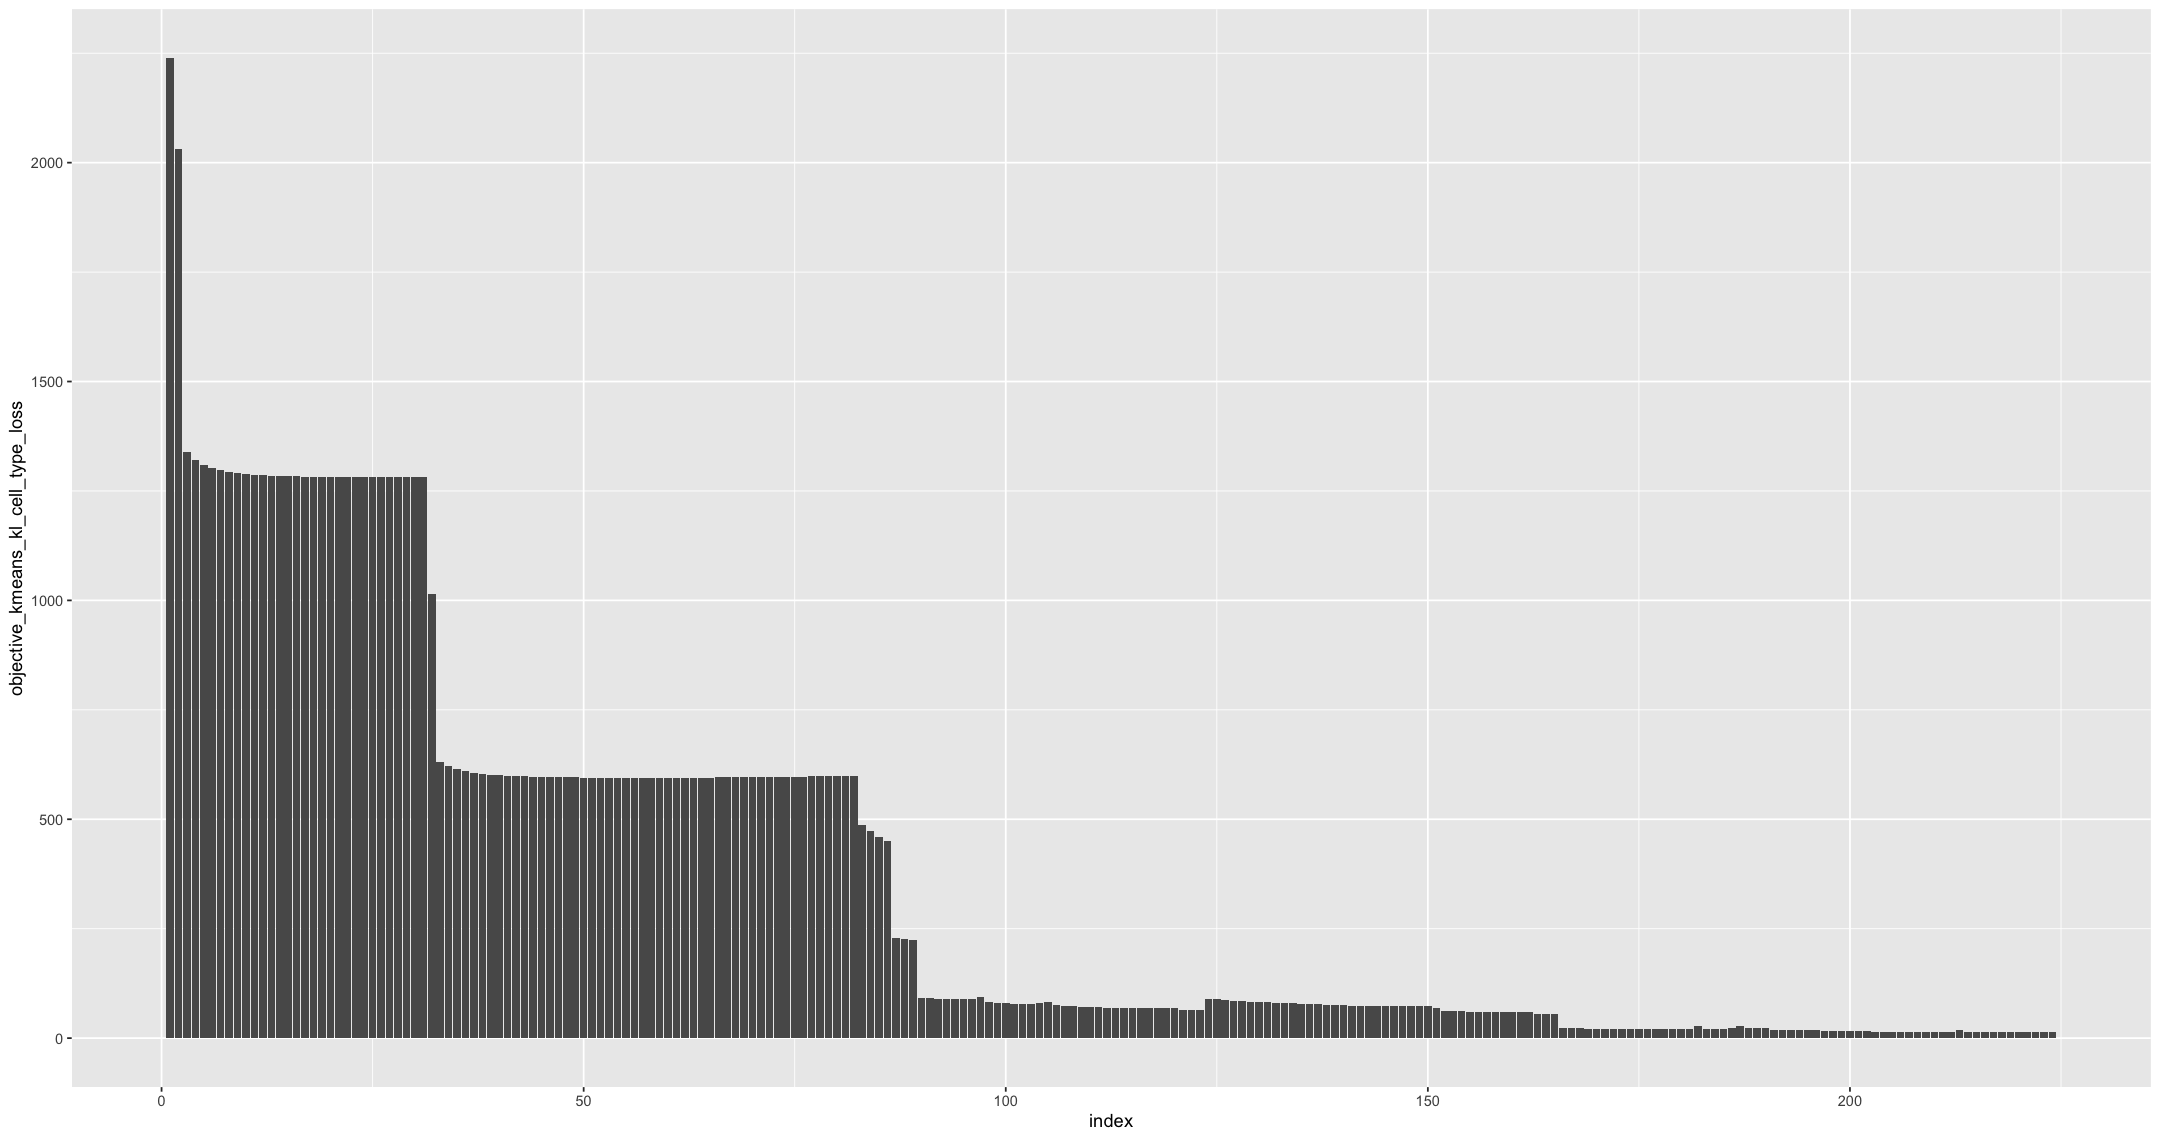

In [66]:
loss %>% ggplot(aes(x=index,y=objective_kmeans_kl_cell_type_loss)) + geom_col()

In [67]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS Catalina 10.15.6

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/3.6/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.6/Resources/lib/libRlapack.dylib

locale:
[1] C/UTF-8/C/C/C/C

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] presto_1.0.0            lisi_1.0                ggrepel_0.8.2          
 [4] patchwork_1.0.1         ggthemes_4.2.0          singlecellmethods_0.1.0
 [7] dincta_0.1.0            harmony_0.99.9          Rcpp_1.0.5             
[10] forcats_0.5.0           stringr_1.4.0           dplyr_1.0.2            
[13] purrr_0.3.4             readr_1.3.1             tidyr_1.1.2            
[16] tibble_3.0.4            ggplot2_3.3.2           tidyverse_1.3.0        
[19] data.table_1.12.8      

loaded via a namespace (and not attached):
 [1] 